In [ ]:
import sys
sys.path.append(r'C:\Users\Mechano_2\PycharmProjects\scientificProject')
sys.path
import os
os.chdir("./scientificProject")

In [3]:
import cv2
import glob
import sys
import os
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from functools import partial
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
def load_file(path,x,y,x_1,y_1):
    files = glob.glob(path+'./*.jpg')
    if not files:
        print("Chck Phath")
        sys.exit()
    img = []
    for index, i in enumerate(tqdm.tqdm((files))):
        im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)[y:y_1, x:x_1]
        if index == 0:
            ref_img = im
            plt.imshow(ref_img)
            plt.close()
        img.append(np.stack([im, ref_img], axis = 2))
    return np.array(img)

features = load_file('data/DIC/', 217-30, 295-100,217+170,295+100)
target = np.array(pd.read_csv('data/DIC/target.csv', encoding='CP949'))[:,3]
min_max_scaler  = MinMaxScaler()
target = min_max_scaler.fit_transform(target.reshape(-1, 1))
target = savgol_filter(target.flatten(),201,1).reshape(-1, 1)


100%|█████████████████████████████████████████████████████████████████████████████| 3574/3574 [00:15<00:00, 224.32it/s]


In [4]:
delete_index = [i for i in range(1,375)]
target = np.delete(target, delete_index, 0)
features = np.delete(features, delete_index, 0)

In [5]:
X_train,  X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.15, random_state=0)
X_train = X_train / 255.0
X_valid = X_valid / 255.0

X_valid,  X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0)

In [6]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[200, 200, 2]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=1),
])


In [7]:
model.compile(loss="mse", optimizer="RMSprop", metrics=["mse"])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))
score = model.evaluate(X_valid, y_valid)

Train on 2720 samples, validate on 240 samples
Epoch 1/30
  32/2720 [..............................] - ETA: 2:34

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-7-10dbbe69d4f0>:2) ]] [Op:__inference_distributed_function_1557]

Function call stack:
distributed_function


In [ ]:
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]
epoch_count = range(1, len(training_loss)+1)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0,0.1)
plt.show()

In [ ]:
predicted_target = model.predict(features/255)

In [ ]:
plt.plot(target,label='target')
plt.plot(predicted_target,color='red',label='predict')
plt.legend()

In [ ]:
model.save('DIC.h5')

In [ ]:
np.save('DIC_training_loss',training_loss)
np.save('DIC_test_loss',test_loss)

In [4]:
import numpy as np
training_loss = np.load('DIC_training_loss.npy')
test_loss = np.load('DIC_test_loss.npy')
ml_training_loss=np.load('ml_training_loss.npy')
ml_testing_loss=np.load('test_loss.npy')

(0.0, 0.1)

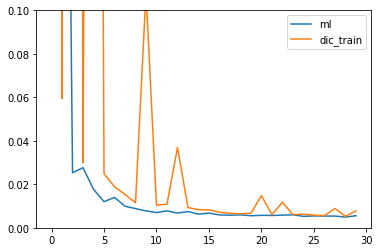

In [11]:
import matplotlib.pyplot as plt
plt.plot(ml_training_loss,label='ml')
plt.plot(ml_testing_loss,label='test_ml')
plt.plot(training_loss,label='dic_train')
plt.plot(test_loss, label='dic_test')
plt.legend()
plt.ylim(0,0.1)

C:\Users\Mechano_2\anaconda3\envs\final\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


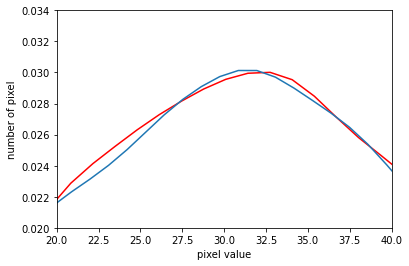

In [26]:
import cv2
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
min= MinMaxScaler()


img = features[1][:,:,0]

img2 = features[1900][:,:,0]


fig, ax = plt.subplots()
sns.kdeplot(data=img.ravel(),color='red',label='Ref',ax=ax)
sns.kdeplot(data=img2.ravel(),label='Deformed',ax=ax)

plt.ylabel('number of pixel')
plt.xlabel('pixel value')
ax.set_xlim(20,40)
ax.set_ylim(0.020,0.034)
plt.savefig('sp_zoom.png',bbox='tight')